In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster, OutPiecewiseLinearChangepoints, PiecewiseLinearChangepoints
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict

import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import theano.tensor as tt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [3]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [4]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [5]:
groups = generate_groups_data_flat(prison_pivot, groups_input, seasonality=4, h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [6]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [390]:
p_s_fit = []
p_s_predict = []

for i in range(groups['train']['s']):    
    with pm.Model() as model:

        period = pm.Gamma('period', 40, 10)


        l_t = pm.InverseGamma('l_t', 4, 40, testval=7)
        l_p = pm.InverseGamma('l_p', 4, 40, testval=7)
        η_trend = pm.HalfNormal('η_trend',0.5, testval=0.5)
        η_per = pm.HalfNormal('η_per',0.5, testval=0.5)
        σ  = pm.HalfNormal("σ",  sigma=0.1, testval=0.1)

        a = pm.Normal('a', np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])),0.1) 
        b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

        mu_func = pm.gp.mean.Linear(intercept = a,
                                   coeffs = b)


        # cov function for the GP 
        cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                + η_per * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                + pm.gp.cov.WhiteNoise(σ))

        gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f = gp.prior('f', X=X, reparameterize=True)

        y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])
        mp = pm.find_MAP(maxeval=5000, progressbar = False)
        
        pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                      vars=[y_pred], 
                                      samples=200,
                                      progressbar=False)

        f_n = gp.conditional('f_n', Xnew=X_new)

        y_pred_new = pm.Poisson("y_pred_new", 
                                mu=tt.exp(f_n), 
                                shape=X_new.shape[0])

        pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200,
                                                  progressbar = False)

    print(str(i)+'/'+str(groups['train']['s']-1))
    p_s_fit.append(pred_samples_fit['y_pred'])
    p_s_predict.append(pred_samples_predict['y_pred_new'])

0/31
1/31
2/31
3/31
4/31
5/31
6/31
7/31
8/31
9/31
10/31
11/31
12/31
13/31
14/31
15/31
16/31
17/31
18/31
19/31
20/31
21/31
22/31
23/31
24/31
25/31
26/31
27/31
28/31
29/31
30/31
31/31


In [391]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 0, 2).reshape(200, 40*32)
p_s_predict = p_s_predict.transpose(1, 0, 2).reshape(200, 48*32)
p_s_fit_d = {}
p_s_predict_d = {}
p_s_fit_d['y_pred'] = p_s_fit
p_s_predict_d['y_pred_new'] = p_s_predict

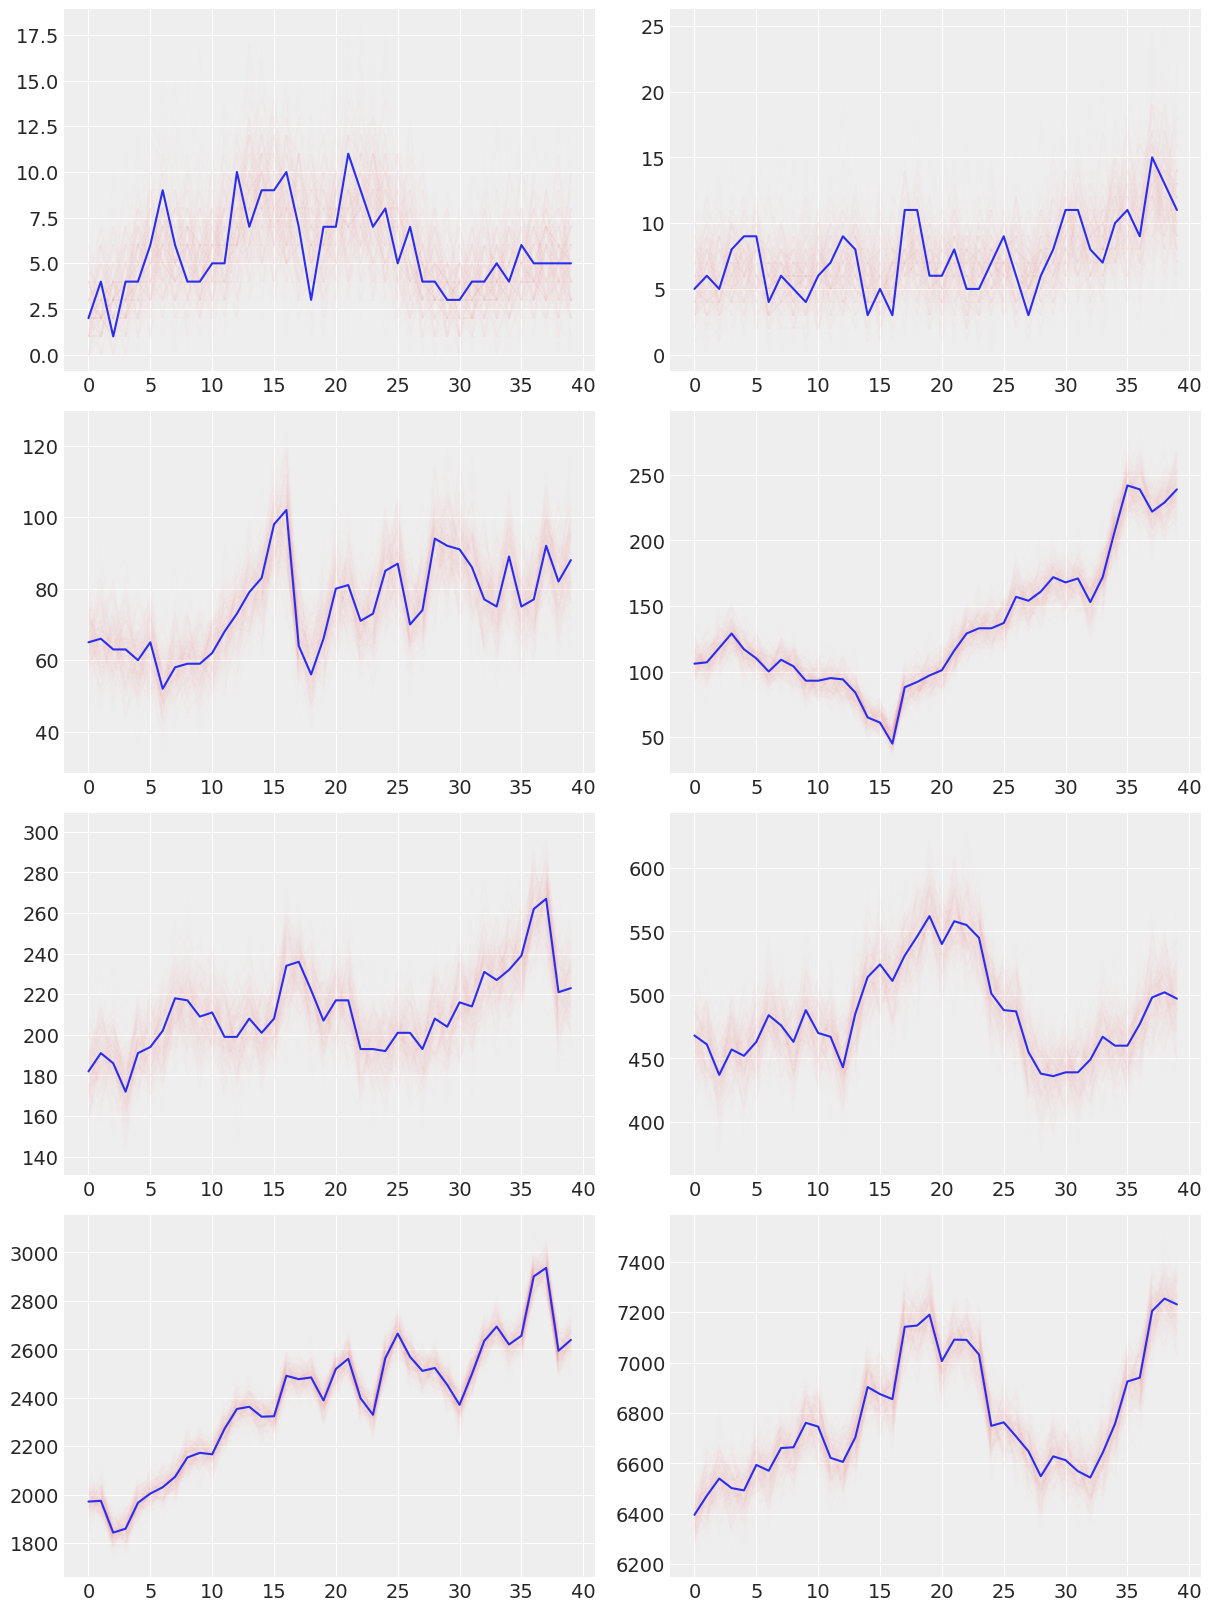

In [392]:
visualize_fit(groups, p_s_fit_d, 8)

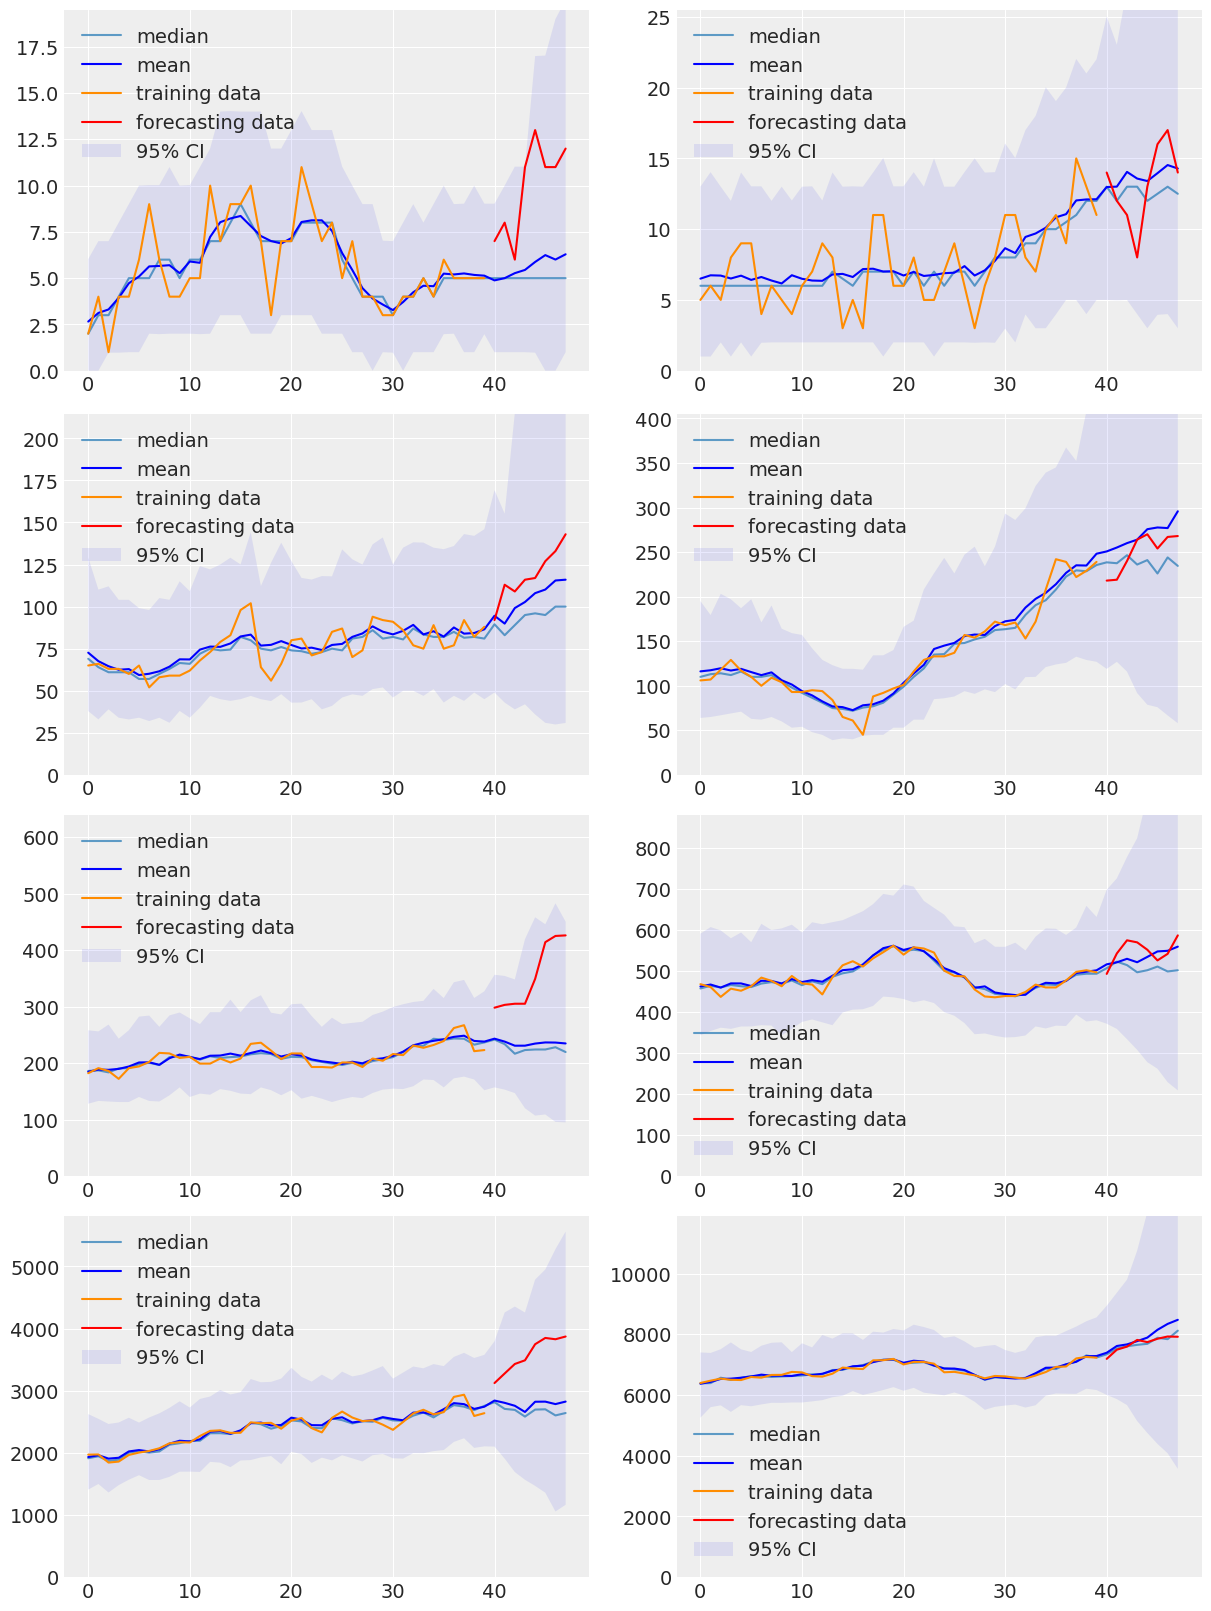

In [393]:
visualize_predict(groups, p_s_predict_d, 8)

In [394]:
results = calculate_metrics(p_s_predict_d, groups)
metrics_to_table(groups, results)

,bottom,total,state,gender,legal,all
mase,2.366,0.775,1.698,0.594,2.923,2.189
rmse,141.072,881.463,323.332,483.459,1821.58,223.338


# Test a single series

Prior selection for GPs: 
https://betanalpha.github.io/assets/case_studies/gaussian_processes.html

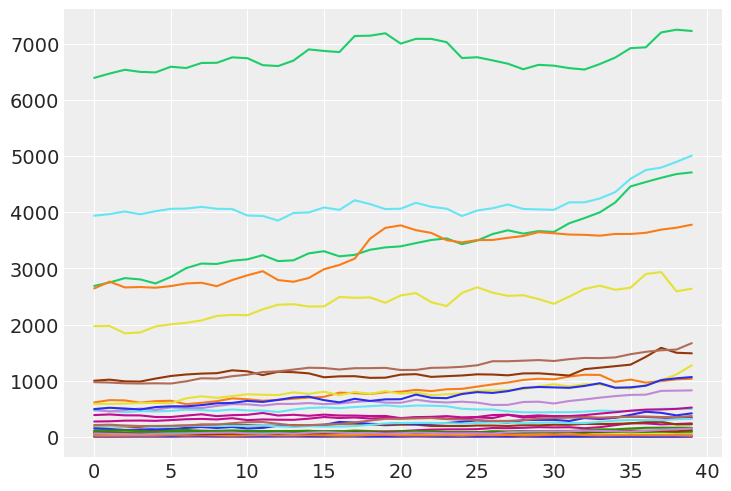

In [7]:
series = np.arange(groups['train']['s'])
series_v = groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series[0]:series[-1]+1]
series_v_pred = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series[0]:series[-1]+1]

plt.plot(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series[0]:series[-1]+1]);

In [8]:
groups = generate_groups_data_matrix(groups)

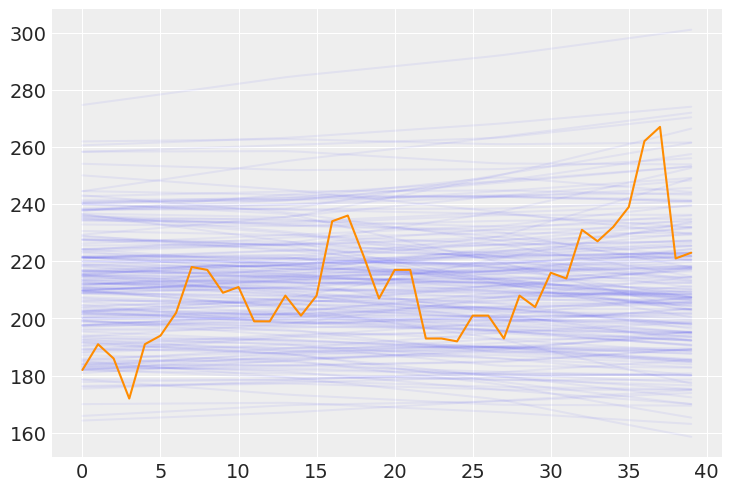

In [170]:
# with piecewise outside GPs

with pm.Model() as model:
    l_t1 = pm.InverseGamma('l_t1', 4, groups['train']['n']/4)
    l_p1 = pm.InverseGamma('l_p1', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend1 = pm.HalfNormal('η_trend1',0.001)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    η_per1 = pm.HalfNormal('η_per1', 0.002)
    σ1  = pm.HalfNormal("σ1",  sigma=0.0001)
    
    l_t2 = pm.InverseGamma('l_t2', 4, groups['train']['n']/4)
    l_p2 = pm.InverseGamma('l_p2', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend2 = pm.HalfNormal('η_trend2',0.001)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    η_per2 = pm.HalfNormal('η_per2', 0.002)
    σ2  = pm.HalfNormal("σ2",  sigma=0.0001)


    a = pm.Normal('a',
                  tt.log(np.mean(series_v, axis=0)),
                  0.1,
                  shape=len(series))
    
    mu_func1 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov1 = (η_trend1**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t1)
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           + η_per1**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p1)
            + pm.gp.cov.WhiteNoise(σ1))
    
    
    mu_func2 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov2 = (η_trend2**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t2)
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           + η_per2**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p2)
            + pm.gp.cov.WhiteNoise(σ2))
    
    gp1 = pm.gp.Latent(mean_func = mu_func1, cov_func = cov1)
    gp2 = pm.gp.Latent(mean_func = mu_func2, cov_func = cov2)
    f1 = gp1.prior('f1', X=X, reparameterize=True)
    f2 = gp2.prior('f2', X=X, reparameterize=True)
    f_1  = tt.tile(f1, (len(series), 1)).T * groups['train']['groups_idx']['gender'].reshape(1,-1)
    f_2  = tt.tile(f2, (len(series), 1)).T * groups['train']['groups_idx']['legal'].reshape(1,-1)
    
    b = pm.Laplace('b', 0, 0.001, shape=(changepoints, groups['train']['s']))
    k = pm.Normal('k', 0,0.001, shape=groups['train']['s'])
    m = pm.Normal('m', 0,0.001, shape=groups['train']['s'])
    
    
    piece = OutPiecewiseLinearChangepoints(b = b,
                                          changepoints = changepoints_t,
                                          groups = groups,
                                          k = k,
                                          m = m).build(X)

    f_ = pm.Deterministic('f_',tt.exp(f_1 + f_2 + a.reshape((1,-1)) + piece))
    prior_checks = pm.sample_prior_predictive(200)

    #y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])
    #mp = pm.find_MAP(maxeval=15000)
plt.plot(prior_checks['f_'][:,:,4].T, color='b', alpha=0.05)
plt.plot(series_v[:,4], color='darkorange');
#plt.plot(series_v[:,1], color='g')


In [294]:
changepoints = 2
changepoints_t = np.linspace(0, groups['train']['n'], changepoints + 2)[1:-1]
changepoints_t

array([13.33333333, 26.66666667])

In [339]:
with pm.Model() as model:
    l_t1 = pm.InverseGamma('l_t1', 4, groups['train']['n']/4)
    #l_p1 = pm.InverseGamma('l_p1', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend1 = pm.HalfNormal('η_trend1',0.001)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    #η_per1 = pm.HalfNormal('η_per1', 0.005)
    σ1  = pm.HalfNormal("σ1",  sigma=0.001)
    
    l_t2 = pm.InverseGamma('l_t2', 4, groups['train']['n']/4)
    #l_p2 = pm.InverseGamma('l_p2', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend2 = pm.HalfNormal('η_trend2',0.001)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    #η_per2 = pm.HalfNormal('η_per2', 0.005)
    σ2  = pm.HalfNormal("σ2",  sigma=0.001)
    
    l_t3 = pm.InverseGamma('l_t3', 4, groups['train']['n']/4)
    #l_p3 = pm.InverseGamma('l_p3', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend3 = pm.HalfNormal('η_trend3',0.002)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    #η_per3 = pm.HalfNormal('η_per3', 0.005)
    σ3  = pm.HalfNormal("σ3",  sigma=0.001)


    a = pm.Normal('a',
                  tt.log(np.mean(series_v, axis=0)),
                  0.1,
                  shape=len(series))
    
    mu_func1 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov1 = (η_trend1**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t1)
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           #+ η_per1**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p1)
            + pm.gp.cov.WhiteNoise(σ1))
    
    
    mu_func2 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov2 = (η_trend2**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t2)
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           #+ η_per2**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p2)
            + pm.gp.cov.WhiteNoise(σ2))

    
    mu_func3 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov3 = (η_trend3**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t3)
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           #+ η_per3**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p3)
            + pm.gp.cov.WhiteNoise(σ3))
    
    gp1 = pm.gp.Latent(mean_func = mu_func1, cov_func = cov1)
    gp2 = pm.gp.Latent(mean_func = mu_func2, cov_func = cov2)
    gp3 = pm.gp.Latent(mean_func = mu_func3, cov_func = cov3)
    f1 = gp1.prior('f1', X=X, reparameterize=True)
    f2 = gp2.prior('f2', X=X, reparameterize=True)
    f3 = gp2.prior('f3', X=X, reparameterize=True)
    f_1  = tt.tile(f1, (len(series), 1)).T * groups['train']['groups_idx']['gender'].reshape(1,-1)
    f_2  = tt.tile(f2, (len(series), 1)).T * groups['train']['groups_idx']['legal'].reshape(1,-1)
    f_3  = tt.tile(f3, (len(series), 1)).T * groups['train']['groups_idx']['state'].reshape(1,-1)
    
    #b = pm.Laplace('b', 0, 0.001, shape=(changepoints, groups['train']['s']))
    #k = pm.Normal('k', 0,0.001, shape=groups['train']['s'])
    #m = pm.Normal('m', 0,0.001, shape=groups['train']['s'])
    
    #piece = OutPiecewiseLinearChangepoints(b = b,
    #                                      changepoints = changepoints_t,
    #                                      groups = groups,
    #                                      k = k,
    #                                      m = m).build(X)
    
    #b = pm.Laplace('b', 0, 0.001, shape=(changepoints, groups['train']['s']))
    #k = pm.Normal('k', 0,0.001, shape=groups['train']['s'])
    #m = pm.Normal('m', 0,0.001, shape=groups['train']['s'])
    
    #piece = OutPiecewiseLinearChangepoints(b = b,
    #                                      changepoints = changepoints_t,
    #                                      groups = groups,
    #                                      k = k,
    #                                      m = m).build(X)
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f_1 + f_2 + f_3 + a), observed=series_v)
    #mp = pm.find_MAP()
    trace_vi = pm.fit(100000)
    trace_vi_samples = trace_vi.sample()

Finished [100%]: Average Loss = 8,483.7


In [ ]:
with pm.Model() as model:
    l_t1 = pm.InverseGamma('l_t1', 4, groups['train']['n']/4)
    #l_p1 = pm.InverseGamma('l_p1', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend1 = pm.HalfNormal('η_trend1',0.01)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    #η_per1 = pm.HalfNormal('η_per1', 0.05)
    #σ1  = pm.HalfNormal("σ1",  sigma=0.001)
    
    l_t2 = pm.InverseGamma('l_t2', 4, groups['train']['n']/4)
    #l_p2 = pm.InverseGamma('l_p2', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend2 = pm.HalfNormal('η_trend2',0.01)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    #η_per2 = pm.HalfNormal('η_per2', 0.05)
    #σ2  = pm.HalfNormal("σ2",  sigma=0.001)
    
    l_t3 = pm.InverseGamma('l_t3', 4, groups['train']['n']/4)
    #l_p3 = pm.InverseGamma('l_p3', 4, groups['train']['n'])
    #c = pm.Normal('c', 0, 1)

    η_trend3 = pm.HalfNormal('η_trend3',0.01)
    #η_ts = pm.HalfNormal('η_ts', 0.03)
    #η_per3 = pm.HalfNormal('η_per3', 0.05)
    #σ3  = pm.HalfNormal("σ3",  sigma=0.001)


    a = pm.Normal('a',
                  tt.log(np.mean(series_v, axis=0)),
                  0.1,
                 shape=series_v.shape[1])
    
    mu_func1 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov1 = (η_trend1**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t1))
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           #+ η_per1**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p1)
            #+ pm.gp.cov.WhiteNoise(σ1))
    
    
    mu_func2 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov2 = (η_trend2**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t2))
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           #+ η_per2**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p2)
            #+ pm.gp.cov.WhiteNoise(σ2))

    
    mu_func3 = pm.gp.mean.Zero()
    #b = pm.Normal('b', 0, 1)
    
    #mu_func = LogLinear(b=b)
    cov3 = (η_trend3**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t3))
           #+ η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           #+ η_per3**2 * pm.gp.cov.Periodic(1, period=4, ls=l_p3)
            #+ pm.gp.cov.WhiteNoise(σ3))
    
    gp1 = pm.gp.Latent(mean_func = mu_func1, cov_func = cov1)
    gp2 = pm.gp.Latent(mean_func = mu_func2, cov_func = cov2)
    gp3 = pm.gp.Latent(mean_func = mu_func3, cov_func = cov3)
    f1 = gp1.prior('f1', X=X, reparameterize=True)
    f2 = gp2.prior('f2', X=X, reparameterize=True)
    f3 = gp3.prior('f3', X=X, reparameterize=True)
    f_1  = tt.tile(f1, (len(series), 1)).T * groups['train']['groups_idx']['gender'].reshape(1,-1)
    f_2  = tt.tile(f2, (len(series), 1)).T * groups['train']['groups_idx']['legal'].reshape(1,-1)
    f_3  = tt.tile(f3, (len(series), 1)).T * groups['train']['groups_idx']['state'].reshape(1,-1)
    
    #b = pm.Laplace('b', 0, 0.001, shape=(changepoints, groups['train']['s']))
    #k = pm.Normal('k', 0,0.001, shape=groups['train']['s'])
    #m = pm.Normal('m', 0,0.001, shape=groups['train']['s'])
    
    #piece = OutPiecewiseLinearChangepoints(b = b,
    #                                      changepoints = changepoints_t,
    #                                      groups = groups,
    #                                      k = k,
    #                                      m = m).build(X)
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f_1 + f_2 + f_3 + a), observed=series_v)
    #prior_checks = pm.sample_prior_predictive(200)
    trace_vi = pm.fit(100000)
    trace_vi_samples = trace_vi.sample()

In [ ]:
with model:
    f_n1_c = gp1.conditional('f_n1_c', Xnew=X_new)
    f_n2_c = gp2.conditional('f_n2_c', Xnew=X_new)
    f_n3_c = gp3.conditional('f_n3_c', Xnew=X_new)
    f_n1  = tt.tile(f_n1_c, (len(series), 1)).T * groups['train']['groups_idx']['gender'].reshape(1,-1)
    f_n2  = tt.tile(f_n2_c, (len(series), 1)).T * groups['train']['groups_idx']['legal'].reshape(1,-1)
    f_n3  = tt.tile(f_n3_c, (len(series), 1)).T * groups['train']['groups_idx']['legal'].reshape(1,-1)

    
    #piece = OutPiecewiseLinearChangepoints(b = b,
    #                              changepoints = changepoints_t,
    #                              groups = groups,
    #                              k = k,
    #                              m = m).build(X_new)

    y_pred_new1 = pm.Poisson("y_pred_new1", 
                            mu=tt.exp(f_n1 + f_n2 + f_n3 + a ), 
                            shape=(X_new.shape[0], len(series)))

    pred_samples0 = pm.sample_posterior_predictive(trace_vi_samples, 
                                              vars=[y_pred_new1], 
                                              samples=200,
                                              progressbar = False)

In [360]:
with model:
    f_n1 = gp1.conditional('f_n1', Xnew=X_new)

    y_pred_new1 = pm.Poisson("y_pred_new1", 
                            mu=tt.exp(f_n1 + a ), 
                            shape=X_new.shape[0])

    pred_samples0 = pm.sample_posterior_predictive(trace_vi_samples, 
                                              vars=[y_pred_new1], 
                                              samples=200,
                                              progressbar = False)

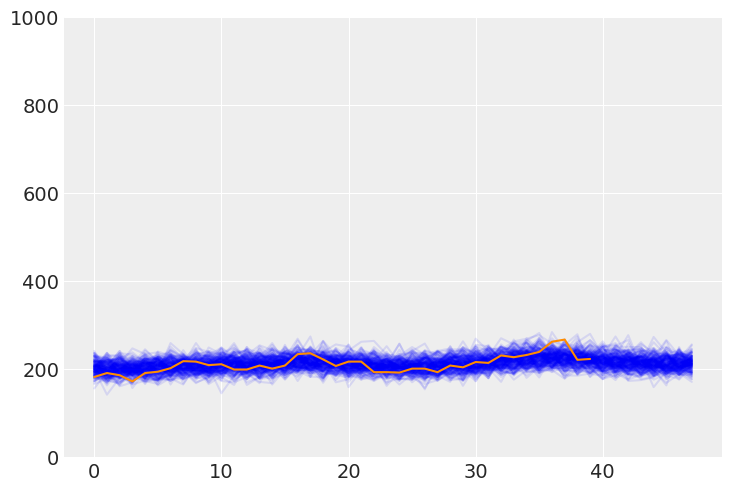

In [362]:
plt.plot(pred_samples0['y_pred_new1'].T, color='b', alpha=0.1)
plt.plot(series_v[:,4],color='darkorange')
plt.ylim(0, 1000);

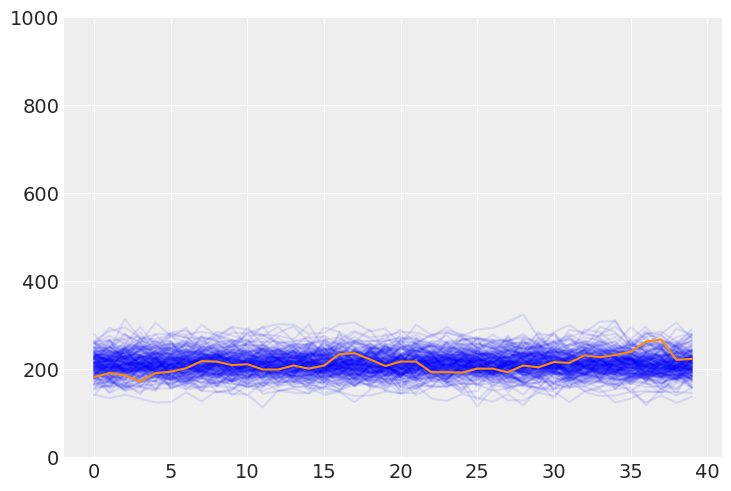

In [354]:
plt.plot(prior_checks['y_pred'].T, color='b', alpha=0.1)
plt.plot(series_v[:,4],color='darkorange')
plt.ylim(0, 1000);

In [283]:
with pm.Model() as model:    

    a = pm.Normal('a',
                  tt.log(np.mean(series_v, axis=0)),
                  0.1,
                  shape=len(series))
 
    b = pm.Laplace('b', 0, 0.0001, shape=(changepoints, groups['train']['s']))
    k = pm.Normal('k', 0,0.0001, shape=groups['train']['s'])
    m = pm.Normal('m', 0,0.0001, shape=groups['train']['s'])
    
    
    piece = OutPiecewiseLinearChangepoints(b = b,
                                          changepoints = changepoints_t,
                                          groups = groups,
                                          k = k,
                                          m = m).build(X)
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(a + piece), shape=(40, 32))

    prior_checks = pm.sample_prior_predictive(500)

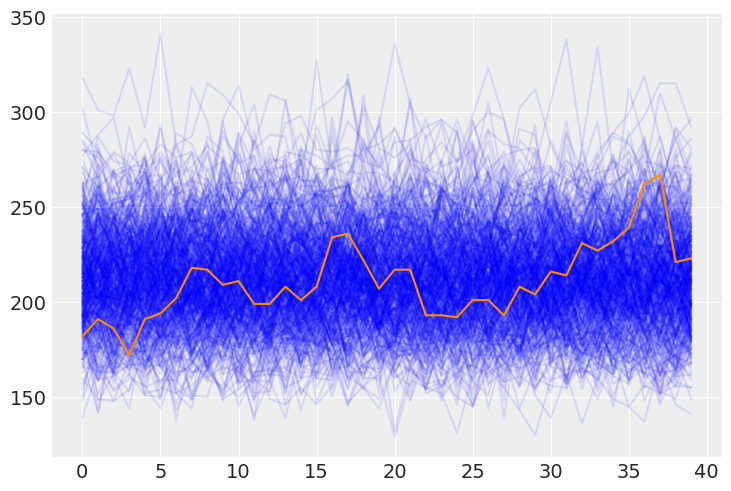

In [284]:
plt.plot(prior_checks['y_pred'][:,:,4].T, color='b', alpha=0.1)
plt.plot(series_v[:,4],color='darkorange');

In [286]:
# with piecewise outside GPs

with pm.Model() as model:    

    a = pm.Normal('a',
                  tt.log(np.mean(series_v, axis=0)),
                  1,
                  shape=len(series))
 
    b = pm.Laplace('b', 0, 0.001, shape=(changepoints, groups['train']['s']))
    k = pm.Normal('k', 0,0.001, shape=groups['train']['s'])
    m = pm.Normal('m', 0,0.001, shape=groups['train']['s'])
    
    
    piece = OutPiecewiseLinearChangepoints(b = b,
                                          changepoints = changepoints_t,
                                          groups = groups,
                                          k = k,
                                          m = m).build(X)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(a + piece), observed=series_v)
    #mp = pm.find_MAP()
    trace_vi = pm.fit(100000)
    trace_vi_samples = trace_vi.sample()

Finished [100%]: Average Loss = 6,655.6


In [287]:
with model:

    pred_samples0 = pm.sample_posterior_predictive(trace_vi_samples, 
                                              vars=[y_pred], 
                                              samples=200,
                                              progressbar = False)

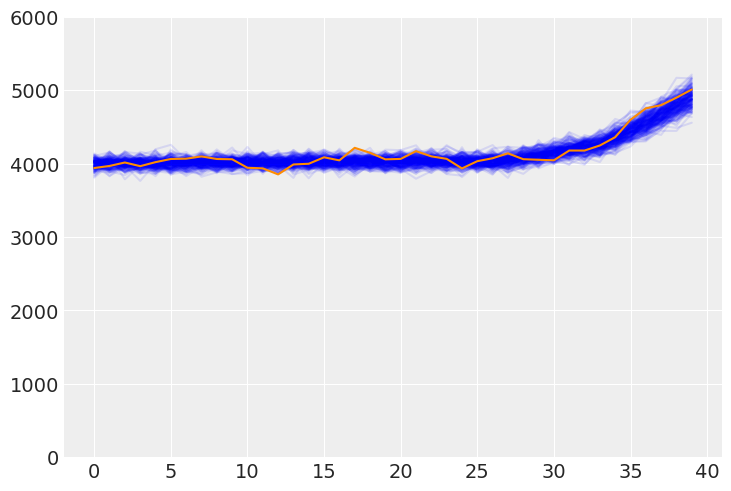

In [288]:
plt.plot(pred_samples0['y_pred'][:,:,15].T, color='b', alpha=0.1)
plt.plot(series_v[:,15],color='darkorange') 
plt.ylim(0, 6000);

In [208]:
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [174]:
class OutPiecewiseLinearChangepoints():
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise


In [ ]:
with model:

    pred_samples0 = pm.sample_posterior_predictive(trace_vi_samples, 
                                              vars=[piece], 
                                              samples=200,
                                              progressbar = False)

In [ ]:
plt.plot(np.exp(pred_samples0[None][:,:,2].T), color='b', alpha=0.1)
plt.plot(series_v[:,2], color="darkorange")
plt.ylim(0, 1000000);

In [ ]:
plt.plot(np.exp(pred_samples0[None][:,:,2].T), color='b', alpha=0.1);

In [ ]:
def create_changepoints(X, changepoints):
    return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

In [ ]:
A = create_changepoints(X, changepoints_t)

In [ ]:
(self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))


In [ ]:
A.eval().shape

In [ ]:
np.mean(trace_vi_samples['b'], axis=0)[:,0].shape

In [ ]:
plt.plot(trace_vi_samples['b'][:,:,0].T);

In [ ]:
np.mean(trace_vi_samples['b'], axis=0)[:,2]

In [ ]:
A.eval()

In [ ]:
np.exp(np.dot(A.eval(), np.mean(trace_vi_samples['b'], axis=0)[:,2].reshape(-1, 1))*X)

In [ ]:
plt.plot(np.mean(trace_vi_samples['k'], axis=0)[2] + np.dot(A.eval(), np.mean(trace_vi_samples['b'], axis=0)[:,2].reshape(-1, 1))*X);

In [ ]:
np.mean(trace_vi_samples['k'], axis=0)[0]

In [ ]:
plt.plot(trace_vi_samples['k'][:,0]);

In [ ]:
plt.plot(trace_vi_samples['b'][:,:,2].T, color='b', alpha=0.1);

In [ ]:
from pymc3.gp.util import plot_gp_dist
#fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

In [ ]:
_, ax = plt.subplots(int(len(series)/2), 2, figsize=(20, 60))

ax = ax.ravel()

for i in range(len(series)):
    plot_gp_dist(ax[i], pred_samples0['y_pred_new1'][:,:,i], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
    ax[i].plot(np.mean(pred_samples0['y_pred_new1'][:,:,i], axis=0), label='mean')
    ax[i].plot(np.median(pred_samples0['y_pred_new1'][:,:,i], axis=0), label='median', color='green')
    ax[i].plot(np.arange(groups['train']['n']),series_v[:,i], label='data', color='darkorange')
    ax[i].plot(np.arange(groups['train']['n'], groups['predict']['n']), series_v_pred[:,i][groups['train']['n']:groups['predict']['n']], label='data to forecast', color='red')
    ax[i].set_ylim(0,max(series_v_pred[:,i])*2)
    ax[i].legend();

In [ ]:
pm.traceplot(trace_vi_samples, var_names=['~f'], filter_vars ='like');